In [1]:
import h5py
import matplotlib
import matplotlib.pyplot as plt
# from habitat.utils.visualizations import maps
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap
import numpy as np
import os
import cv2
import ast
from scipy.spatial.transform import Rotation as R
from tqdm import tqdm
from PIL import Image
import json
from pathlib import Path
import faiss
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
path_to_global_descriptors = '/media/cds-s/data/Datasets/Habitat/HF_Net_output/global_descriptors/'

In [ ]:
path_to_global_descriptors = '/media/cds-s/data/Datasets/Habitat/NetVLAD/global_descriptors/'

In [ ]:
query_descriptor_paths  = list(Path(path_to_global_descriptors).glob('*/*query*'))
database_descriptor_paths  = list(Path(path_to_global_descriptors).glob('*/*database*'))

In [ ]:
num_keypoints = 32768
query_descriptors = []
database_descriptors = []
dbFeats = np.empty((len(database_descriptor_paths), num_keypoints))
qFeats = np.empty((len(query_descriptor_paths), num_keypoints))

for i, query_descriptor_path in enumerate(tqdm(query_descriptor_paths)):
    query_descriptor_filename = str(query_descriptor_path)
#     map_name = query_descriptor_filename.split('/')[-2]
    with open(query_descriptor_filename, 'rb') as f:
        query_descriptor = np.load(f)
    query_descriptors.append(query_descriptor)
    qFeats[i,:] = query_descriptor
    
for i, database_descriptor_path in enumerate(tqdm(database_descriptor_paths)):
    database_descriptor_filename = str(database_descriptor_path)
#     map_name = database_descriptor_filename.split('/')[-2]
    with open(database_descriptor_filename, 'rb') as f:
        database_descriptor = np.load(f)
    database_descriptors.append(database_descriptor)
    dbFeats[i,:] = database_descriptor

In [ ]:
qFeats = qFeats.astype('float32')
dbFeats = dbFeats.astype('float32')
faiss_index = faiss.IndexFlatL2(num_keypoints)
faiss_index.add(dbFeats)
distances, predictions = faiss_index.search(qFeats, 100)

In [10]:
def quaternion_to_rotation_matrix(quaternion_wxyz):
    r = R.from_quat([quaternion_wxyz[1], quaternion_wxyz[2], quaternion_wxyz[3], quaternion_wxyz[0]])
    matrix = r.as_matrix()
    matrix[:3,2] = -matrix[:3,2]
    matrix[:3,1] = -matrix[:3,1]
    return matrix

In [9]:
def get_pose_from_hdf5_file(path_to_hdf5_files, image_filename):
    image_filename = image_filename.rstrip('.png')
    hdf5_filename = '_'.join(image_filename.split('_')[:2]) + '.hdf5'
    
    map_name = image_filename.split('_')[0]
    if map_name == "1LXtFkjw3qL":
        map_name += "_point0"
    if map_name == "1pXnuDYAj8r":
        map_name += "_point0"
    if map_name == "5LpN3gDmAk7":
        map_name += "_point0"
    if map_name == "5q7pvUzZiYa":
        map_name += "_point1"
            
    hdf5_filename = '_'.join(image_filename.split('_')[:2]) + '.hdf5'
    hdf5_file = h5py.File(os.path.join(path_to_hdf5_files, map_name, hdf5_filename), 'r')
    is_database = ''
    if image_filename.find('database') != -1:
        is_database = '_base'
    num = int(image_filename.split('_')[-1])
    translation = hdf5_file['gps'+is_database][num]
    orientation = quaternion_to_rotation_matrix(hdf5_file['quat'+is_database][num])
    pose_44 = np.eye(4)
    pose_44[:3,:3] = orientation
    pose_44[:3,3] = translation
    return pose_44

In [ ]:
output = {}
part_output = {}
path_to_hdf5_files = '/media/cds-s/data/Datasets/Habitat/HPointLoc/'
for i, query_global_descriptor_path in tqdm(enumerate(query_descriptor_paths)):
    # Получаем имена query и database изображений
    query_global_descriptor_filename_short = str(query_global_descriptor_path).split('/')[-1]
    query_global_descriptor_filename_short = query_global_descriptor_filename_short.rstrip('.npy')
    num_db = predictions[i][0]
    retrieved_image_path = str(database_descriptor_paths[num_db]).split('/')[-1]
    retrieved_image_path = retrieved_image_path.rstrip('npy')    
    
    # Получаем score близости дескрипторов
    qfeature  = qFeats[i]
    dbfeature = dbFeats[num_db]
    dbfeature = np.reshape(dbfeature, (1,-1))
    qfeature = np.reshape(qfeature, (1,-1))
    simil_score = cosine_similarity(dbfeature, qfeature)[0][0]
    
    # Получаем позы query и database изображений
    db_pose = get_pose_from_hdf5_file(path_to_hdf5_files, retrieved_image_path)
    pose_query = get_pose_from_hdf5_file(path_to_hdf5_files, query_global_descriptor_filename_short)
    
    # Получаем ошибку
    error_pose_db = np.linalg.inv(db_pose) @ pose_query
    dist_error_db = np.sum(error_pose_db[:3, 3]**2) ** 0.5

    error_pose = np.linalg.inv(db_pose) @ pose_query
    dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
    r = R.from_matrix(error_pose[:3, :3])
    rotvec = r.as_rotvec()
    angle_error = (np.sum(rotvec**2)**0.5) * 180 / 3.14159265353
    angle_error = abs(180 - abs(angle_error-180))

    output[query_global_descriptor_filename_short] = {
        "retrieved_image_from_NetVLAD" : retrieved_image_path,
        "image_retrieval_score"       : float(simil_score),
        "translation_error"           : float(dist_error),
        "rotation_error"              : float(angle_error)
        
    }
    
    if dist_error > 0.5:
        part_output[query_global_descriptor_filename_short] = {
            "retrieved_image_from_NetVLAD" : retrieved_image_path,
            "image_retrieval_score"       : float(simil_score),
            "translation_error"           : float(dist_error),
            "rotation_error"              : float(angle_error)

        }

In [ ]:
with open('NetVLAD_retrievals_all.json', 'w') as f:
    json.dump(output, f)
with open('NetVLAD_retrievals_with_trans_error_bigger_05.json', 'w') as f:
    json.dump(part_output, f)

# Подсчет метрик recall локализации выборки при различных порогах

In [2]:
with open('HF-Net_retrievals_with_trans_error_bigger_05.json', 'r') as f:
    part_output = json.load(f)

In [ ]:
i = 0
result = {
    "10" : 0,
    "5"  : 0,
    ""
}
for query in tqdm(part_output.keys()):
    if part_output[query]['translation_error'] < 10:
        i += 1
print("Recall = {}".format(i/len(part_output.keys())))

In [ ]:
len(part_output.keys())

In [24]:
part_output

{'PX4nDJXEHrG_point16_query_0020': {'retrieved_image_from_HF-Net': '5LpN3gDmAk7_point8_database_0001.',
  'image_retrieval_score': 0.5844882726669312,
  'translation_error': 3.2753367464263166,
  'rotation_error': 112.7264982575218},
 'PX4nDJXEHrG_point16_query_0007': {'retrieved_image_from_HF-Net': 'aayBHfsNo7d_point14_database_0002.',
  'image_retrieval_score': 0.6401923894882202,
  'translation_error': 6.103066008898634,
  'rotation_error': 90.22889742792479},
 'PX4nDJXEHrG_point22_query_0025': {'retrieved_image_from_HF-Net': 'JeFG25nYj2p_point8_database_0000.',
  'image_retrieval_score': 0.6408092975616455,
  'translation_error': 9.415359026059537,
  'rotation_error': 79.28671508672227},
 'PX4nDJXEHrG_point7_query_0014': {'retrieved_image_from_HF-Net': 'JeFG25nYj2p_point14_database_0004.',
  'image_retrieval_score': 0.6043363809585571,
  'translation_error': 5.6089394767561,
  'rotation_error': 35.13422321033494},
 'PX4nDJXEHrG_point22_query_0007': {'retrieved_image_from_HF-Net': '

# Метрики Patch-NetVLAD на той же выборке

In [3]:
path_to_hdf5_files = '/media/cds-s/data1/Datasets/Habitat/HPointLoc/'

In [4]:
from collections import defaultdict

In [5]:
def parse_retrieval(path):
    retrieval = defaultdict(list)
    with open(path, 'r') as f:
        for p in f.read().rstrip('\n').split('\n'):
            if p.find('#') != -1:
                continue
#             if len(p.split(',')) == 3:
#             q, r, score = p.split(',')
#             q = q.lstrip('testing/')
#             r = r.lstrip('training/')
#             retrieval[q.rstrip('.png')].append({
#                 r.rstrip('.png') : 1.0
#             })
            if len(p.split(' ')) == 2:
                q, r = p.split(' ')
                retrieval[q.rstrip('.png')].append({
                    r.rstrip('.png') : 1.0
                })
            elif len(p.split(' ')) == 3:
                q, r, score = p.split(' ')
                retrieval[q.rstrip('.png')].append({
                    r.rstrip('.png') : score
                })
            elif len(p.split(' ')) == 4:
                q, r, L2_metric, score = p.split(' ')
                retrieval[q.rstrip('.png')].append({
                    r.rstrip('.png') : score
                })
    return retrieval

In [19]:
loc_pairs = '/media/cds-s/data1/Datasets/Habitat/Patch-NetVLAD/PatchNetVLAD_s_top1_correct.txt'

In [6]:
loc_pairs = '/media/cds-s/data1/Datasets/Habitat/NetVLAD/NetVLAD_all_maps_top_1.txt'

In [16]:
loc_pairs = '/media/cds-s/data1/Datasets/Habitat/HF_Net_output/HF-Net_all_maps.txt'

In [20]:
retrievals = parse_retrieval(loc_pairs)

In [21]:
i = 0
results = {
    "0.5": 0,
    "1": 0,
    "5": 0,
    "10":0
}
num_queries = 0
for query_filename in tqdm(retrievals.keys()):
    if not(query_filename in set(part_output.keys())):
        continue
    num_queries += 1
    retrieved_image_filename = list(retrievals[query_filename][0].keys())[0]
    query_pose = get_pose_from_hdf5_file(path_to_hdf5_files, query_filename)
    retrieval_pose = get_pose_from_hdf5_file(path_to_hdf5_files, retrieved_image_filename)
    
    # Получаем ошибку
    pose_query = query_pose
    db_pose = retrieval_pose
    error_pose_db = np.linalg.inv(db_pose) @ pose_query
    dist_error_db = np.sum(error_pose_db[:3, 3]**2) ** 0.5

    error_pose = np.linalg.inv(db_pose) @ pose_query
    dist_error = np.sum(error_pose[:3, 3]**2) ** 0.5
    r = R.from_matrix(error_pose[:3, :3])
    rotvec = r.as_rotvec()
    angle_error = (np.sum(rotvec**2)**0.5) * 180 / 3.14159265353
    angle_error = abs(180 - abs(angle_error-180))

    if dist_error < 0.5:
        results["0.5"] += 1
    if dist_error < 1:
        results["1"] += 1
    if dist_error < 5:
        results["5"] += 1
    if dist_error < 10:
        results["10"] += 1
for key in results.keys():
    results[key] /= num_queries
print(results)

100%|██████████| 76136/76136 [00:40<00:00, 1897.95it/s]

{'0.5': 0.7027027027027027, '1': 0.7135349635349635, '5': 0.8412698412698413, '10': 0.8900686400686401}


In [12]:
num_queries

9324

In [ ]:
with open('HF-Net_retrievals_with_trans_error_bigger_05.json', 'r') as f:
    part_output = json.load(f)

# Misc

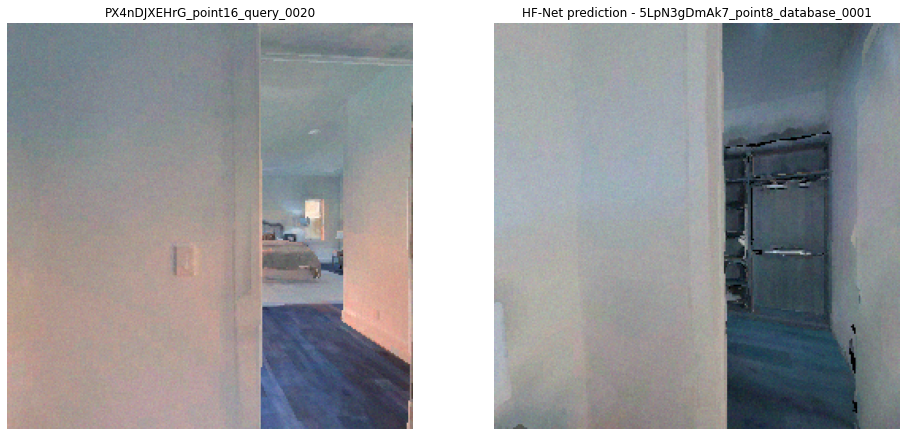

In [23]:
root_dir = '/media/cds-s/data1/Datasets/Habitat/extracted_HPointLoc/'

query_image_filename = "PX4nDJXEHrG_point16_query_0020"
db_image_filename = "5LpN3gDmAk7_point8_database_0001"

query_map = query_image_filename.split('_')[0]
db_map = db_image_filename.split('_')[0]

if query_map == "1LXtFkjw3qL":
     query_map += "_point0"
if query_map == "1pXnuDYAj8r":
    query_map += "_point0"
if query_map == "5LpN3gDmAk7":
    query_map += "_point0"
if query_map == "5q7pvUzZiYa":
    query_map += "_point1"
    
if db_map == "1LXtFkjw3qL":
     db_map += "_point0"
if db_map == "1pXnuDYAj8r":
    db_map += "_point0"
if db_map == "5LpN3gDmAk7":
    db_map += "_point0"
if db_map == "5q7pvUzZiYa":
    db_map += "_point1"

fig=plt.figure(figsize=(16, 16))
columns = 2
rows = 1
img_filenames = []
img = []
w=256
h=256
query_image = cv2.imread(os.path.join(root_dir, query_map, 'images', query_image_filename+'.png'))
db_image = cv2.imread(os.path.join(root_dir, db_map, 'images', db_image_filename+'.png'))
img.append(query_image)
img.append(db_image)
img_filenames.append(query_image_filename)
img_filenames.append(db_image_filename)
for i in range(1, columns*rows+1):
#     img = np.random.randint(10, size=(h,w))
    fig.add_subplot(rows, columns, i)
    plt.axis('off')
    if i == 2:
        plt.title("HF-Net prediction - "+img_filenames[i-1])
    else:
        plt.title(img_filenames[i-1])
    plt.imshow(img[i-1])

In [ ]:
os.path.join(root_dir, db_map, 'images', db_image_filename+'.png')

In [ ]:
pwd